### Business Objective
Conduct a comparative analysis of different transformer models (such as BERT, RoBERTa, GPT-2, etc.) on a specific NLP task (e.g., sentiment analysis, text classification, question answering). The goal is to evaluate their performance, efficiency, and applicability to provide insights into the strengths and weaknesses of each model for selecting the most appropriate solution.

#### Data Details
- The data contains 50000 user reviews of IMDB movies classified as postitive and negative.
- It contains two columns - Reviews and Sentiment

#### Downloading the Dataset
- The Dataset was downloaded from Kaggle.
- Citation -->

  IMDB dataset having 50K movie reviews for natural language processing or Text analytics.
  This is a dataset for binary sentiment classification containing substantially more data than previous benchmark datasets. We provide a set of 25,000 highly polar movie reviews for training and 25,000 for testing. So, predict the number of positive and negative reviews using either classification or deep learning algorithms.
  For more dataset information, please go through the following link,
  http://ai.stanford.edu/~amaas/data/sentiment/

In [1]:
# importing necessary libraries
import os
import re
import time
import pandas as pd
import matplotlib.pyplot as plt
from datasets import load_dataset, Dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
from sklearn.metrics import accuracy_score, f1_score

In [2]:
from google.colab import drive
drive.mount(r'/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [3]:
# Data Cleaning & Preparation
df = pd.read_csv(r"/content/drive/MyDrive/AI_PROJECT/AI_P15/IMDB_Dataset.csv")

In [4]:
# First Five Rows of the table
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [5]:
#dataset dimensions
df.shape

(50000, 2)

In [6]:
# checking if the data has duplicate values
df.duplicated().sum()

np.int64(418)

In [7]:
# removing duplicates
df.drop_duplicates(inplace=True)

In [8]:
# re-cheking if the data has duplicate values
df.duplicated().sum()

np.int64(0)

In [9]:
# checking null values
df.isnull().sum()

,0
review,0
sentiment,0


In [10]:
# checking if the data is imbalanced
df.sentiment.value_counts()

,count
sentiment,
positive,24884
negative,24698


`The dataset is perfectly balanced with equal number of reviews text for the two classes.
0 means that the review is negative and 1 for positive`

In [11]:
df.columns

Index(['review', 'sentiment'], dtype='object')

In [12]:
# Cleaning function to remove HTML tags
def clean_text(text):
    text = re.sub(r'<br\s*/?>', ' ', text) # Remove <br /> tags
    text = re.sub(r'[^a-zA-Z\s]', '', text) # Remove special characters
    return text.lower().strip()

In [13]:
df['review'] = df['review'].apply(clean_text)

In [14]:
df['word_count'] = df['review'].apply(lambda x: len(x.split()))

In [15]:
df.head()

,review,sentiment,word_count
0,one of the other reviewers has mentioned that ...,positive,303
1,a wonderful little production the filming te...,positive,156
2,i thought this was a wonderful way to spend ti...,positive,163
3,basically theres a family where a little boy j...,negative,130
4,petter matteis love in the time of money is a ...,positive,225


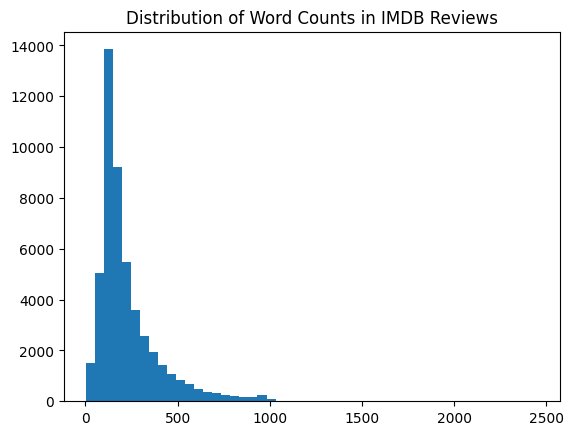

In [16]:
# Visualize review lengths
plt.hist(df['word_count'], bins=50)
plt.title("Distribution of Word Counts in IMDB Reviews")
plt.show()

In [17]:
# Splitting the dataset into train and test
from sklearn.model_selection import train_test_split

In [18]:
df['sentiment'] = df['sentiment'].apply(lambda x: 1 if x=='positive' else 0) # checking the calss label values to binary outputs (0 and 1)

In [19]:
X = df.review # feature
y = df.sentiment # target

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [21]:
# Converting to Hugging Face Dataset objects for the Transformer pipeline
train_ds = Dataset.from_dict({"text": X_train, "label": y_train})
test_ds = Dataset.from_dict({"text": X_test, "label": y_test})

In [22]:
model_name1 = "bert-base-uncased" # BERT model
tokenizer = AutoTokenizer.from_pretrained(model_name1) # getting ptre-trained model

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [23]:
#function for tokenizing
def tokenize_batch(batch):
    return tokenizer(batch["text"], truncation=True, padding="max_length", max_length=128)

In [24]:
tokenized_train = train_ds.map(tokenize_batch, batched=True)
tokenized_test = test_ds.map(tokenize_batch, batched=True)

# Loading Model
model = AutoModelForSequenceClassification.from_pretrained(model_name1, num_labels=2)

# Fine-Tuning Parameters (Hyperparameters)
training_args = TrainingArguments(
    output_dir="./bert_finetuned_imdb",
    eval_strategy= "epoch",
    learning_rate=5e-5,
    per_device_train_batch_size=16,
    num_train_epochs=3,
    optim="adamw_torch",
    weight_decay=0.01,
    save_strategy="epoch",
    load_best_model_at_end=True
)

Map:   0%|          | 0/39665 [00:00<?, ? examples/s]

Map:   0%|          | 0/9917 [00:00<?, ? examples/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Loading weights:   0%|          | 0/199 [00:00<?, ?it/s]

BertForSequenceClassification LOAD REPORT from: bert-base-uncased
Key                                        | Status     | 
-------------------------------------------+------------+-
cls.predictions.transform.LayerNorm.bias   | UNEXPECTED | 
cls.predictions.transform.dense.bias       | UNEXPECTED | 
cls.predictions.bias                       | UNEXPECTED | 
cls.seq_relationship.weight                | UNEXPECTED | 
cls.predictions.transform.dense.weight     | UNEXPECTED | 
cls.seq_relationship.bias                  | UNEXPECTED | 
cls.predictions.transform.LayerNorm.weight | UNEXPECTED | 
classifier.bias                            | MISSING    | 
classifier.weight                          | MISSING    | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
- MISSING	:those params were newly initialized because missing from the checkpoint. Consider training on your downstream task.


In [25]:
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    return {"accuracy": accuracy_score(labels, preds), "f1": f1_score(labels, preds)}

In [26]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_test,
    compute_metrics=compute_metrics)

In [27]:
# EXECUTE FINE-TUNING
print("Starting Fine-Tuning...")
trainer.train() # Milestone: Fine-tune models on the dataset

Starting Fine-Tuning...


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.327852,0.302823,0.885046,0.889556
2,0.194660,0.317413,0.895835,0.896710
3,0.106312,0.455632,0.899869,0.900809


Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

There were missing keys in the checkpoint model loaded: ['bert.embeddings.LayerNorm.weight', 'bert.embeddings.LayerNorm.bias', 'bert.encoder.layer.0.attention.output.LayerNorm.weight', 'bert.encoder.layer.0.attention.output.LayerNorm.bias', 'bert.encoder.layer.0.output.LayerNorm.weight', 'bert.encoder.layer.0.output.LayerNorm.bias', 'bert.encoder.layer.1.attention.output.LayerNorm.weight', 'bert.encoder.layer.1.attention.output.LayerNorm.bias', 'bert.encoder.layer.1.output.LayerNorm.weight', 'bert.encoder.layer.1.output.LayerNorm.bias', 'bert.encoder.layer.2.attention.output.LayerNorm.weight', 'bert.encoder.layer.2.attention.output.LayerNorm.bias', 'bert.encoder.layer.2.output.LayerNorm.weight', 'bert.encoder.layer.2.output.LayerNorm.bias', 'bert.encoder.layer.3.attention.output.LayerNorm.weight', 'bert.encoder.layer.3.attention.output.LayerNorm.bias', 'bert.encoder.layer.3.output.LayerNorm.weight', 'bert.encoder.layer.3.output.LayerNorm.bias', 'bert.encoder.layer.4.attention.output.La

TrainOutput(global_step=7440, training_loss=0.22300417397611885, metrics={'train_runtime': 2920.0203, 'train_samples_per_second': 40.751, 'train_steps_per_second': 2.548, 'total_flos': 7827225008140800.0, 'train_loss': 0.22300417397611885, 'epoch': 3.0})

In [31]:
final_score = trainer.evaluate()
print(f"Final Test Accuracy: {final_score['eval_accuracy']:.4f}")

Final Test Accuracy: 0.8859


In [32]:
model_name2 = "roberta-base" # roBERT model
tokenizer = AutoTokenizer.from_pretrained(model_name2) # getting ptre-trained model

#function for tokenizing
def tokenize_batch(batch):
    return tokenizer(batch["text"], truncation=True, padding="max_length", max_length=128)

tokenized_train = train_ds.map(tokenize_batch, batched=True)
tokenized_test = test_ds.map(tokenize_batch, batched=True)

# Loading Model
model2 = AutoModelForSequenceClassification.from_pretrained(model_name2, num_labels=2)

# Fine-Tuning Parameters (Hyperparameters)
training_args = TrainingArguments(
    output_dir="./bert_finetuned_imdb",
    eval_strategy= "epoch",
    learning_rate=5e-5,
    per_device_train_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.01,
    optim="adamw_torch",
    save_strategy="epoch",
    load_best_model_at_end=True
)

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    return {"accuracy": accuracy_score(labels, preds), "f1": f1_score(labels, preds)}

# trainer (for handling the tuning)
trainer2 = Trainer(
    model=model2,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_test,
    compute_metrics=compute_metrics,
)

# EXECUTE FINE-TUNING
print("Starting Fine-Tuning...")
trainer2.train() # Milestone: Fine-tune models on the dataset

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Map:   0%|          | 0/39665 [00:00<?, ? examples/s]

Map:   0%|          | 0/9917 [00:00<?, ? examples/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Loading weights:   0%|          | 0/197 [00:00<?, ?it/s]

RobertaForSequenceClassification LOAD REPORT from: roberta-base
Key                             | Status     | 
--------------------------------+------------+-
roberta.embeddings.position_ids | UNEXPECTED | 
lm_head.dense.bias              | UNEXPECTED | 
lm_head.bias                    | UNEXPECTED | 
lm_head.dense.weight            | UNEXPECTED | 
lm_head.layer_norm.weight       | UNEXPECTED | 
lm_head.layer_norm.bias         | UNEXPECTED | 
classifier.dense.bias           | MISSING    | 
classifier.dense.weight         | MISSING    | 
classifier.out_proj.bias        | MISSING    | 
classifier.out_proj.weight      | MISSING    | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
- MISSING	:those params were newly initialized because missing from the checkpoint. Consider training on your downstream task.


Starting Fine-Tuning...


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.318503,0.362650,0.879197,0.886938
2,0.225167,0.320735,0.894222,0.894605
3,0.151793,0.399187,0.898457,0.899149


Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

There were missing keys in the checkpoint model loaded: ['roberta.embeddings.LayerNorm.weight', 'roberta.embeddings.LayerNorm.bias', 'roberta.encoder.layer.0.attention.output.LayerNorm.weight', 'roberta.encoder.layer.0.attention.output.LayerNorm.bias', 'roberta.encoder.layer.0.output.LayerNorm.weight', 'roberta.encoder.layer.0.output.LayerNorm.bias', 'roberta.encoder.layer.1.attention.output.LayerNorm.weight', 'roberta.encoder.layer.1.attention.output.LayerNorm.bias', 'roberta.encoder.layer.1.output.LayerNorm.weight', 'roberta.encoder.layer.1.output.LayerNorm.bias', 'roberta.encoder.layer.2.attention.output.LayerNorm.weight', 'roberta.encoder.layer.2.attention.output.LayerNorm.bias', 'roberta.encoder.layer.2.output.LayerNorm.weight', 'roberta.encoder.layer.2.output.LayerNorm.bias', 'roberta.encoder.layer.3.attention.output.LayerNorm.weight', 'roberta.encoder.layer.3.attention.output.LayerNorm.bias', 'roberta.encoder.layer.3.output.LayerNorm.weight', 'roberta.encoder.layer.3.output.Laye

TrainOutput(global_step=7440, training_loss=0.24695365198196903, metrics={'train_runtime': 3049.7591, 'train_samples_per_second': 39.018, 'train_steps_per_second': 2.44, 'total_flos': 7827225008140800.0, 'train_loss': 0.24695365198196903, 'epoch': 3.0})

In [33]:
final_score = trainer2.evaluate()
print(f"Final Test Accuracy: {final_score['eval_accuracy']:.4f}")

Final Test Accuracy: 0.8937


In [63]:
import os

# 2. Save the Model to Disk
# trainer.save_model('./bert')  # Saves to the output_dir defined in TrainingArguments

# Model Size calculations
model_path1 = '/content/bert/model.safetensors'
if os.path.exists(model_path1):
    size_mb1 = os.path.getsize(model_path1) / (1024 * 1024)
else:
    # Fallback if using older pytorch saving method
    model_path1 = os.path.join(training_args.output_dir, "pytorch_model.bin")
    size_mb1 = os.path.getsize(model_path1) / (1024 * 1024)

# run evaluation and capture Inference Time
eval_result1 = trainer.evaluate()
inference_time1 = eval_result1["eval_runtime"]
accuracy1 = eval_result1["eval_accuracy"]
f1_bert = eval_result1["eval_f1"]
model1_size_mb = size_mb1

In [82]:
eval_result1

{'eval_loss': 0.3029239773750305,
 'eval_accuracy': 0.8858525763839871,
 'eval_f1': 0.890246267209618,
 'eval_runtime': 74.1416,
 'eval_samples_per_second': 133.758,
 'eval_steps_per_second': 16.725,
 'epoch': 3.0}

In [64]:
# trainer2.save_model('./robert')

# Model Size calculations
model_path2 = '/content/robert/model.safetensors'
if os.path.exists(model_path2):
    size_mb2 = os.path.getsize(model_path2) / (1024 * 1024)
else:
    # Fallback if using older pytorch saving method
    model_path2 = os.path.join(training_args.output_dir, "pytorch_model.bin")
    size_mb2 = os.path.getsize(model_path2) / (1024 * 1024)

eval_result2 = trainer2.evaluate()
inference_time2 = eval_result2["eval_runtime"]
accuracy2 = eval_result2["eval_accuracy"]
f1_robert = eval_result2["eval_f1"]
model2_size_mb = size_mb2

In [81]:
# --- FINAL REPORT PRINT ---
print(f"COMPARATIVE ANALYSIS REPORT OF BERT AND ROBERTA")
final_report= pd.DataFrame({"Inteference Time":[eval_result1['eval_runtime'],eval_result2['eval_runtime']],
            "Accuracy": [accuracy1,accuracy2],
            "F1 Score": [f1_bert,f1_robert],
            "Model Size": [model1_size_mb, model2_size_mb]}, index = ['Bert','Roberta'])
final_report = final_report.T
final_report

COMPARATIVE ANALYSIS REPORT OF BERT AND ROBERTA


,Bert,Roberta
Inteference Time,74.141600,69.309200
Accuracy,0.885853,0.893718
F1 Score,0.890246,0.894113
Model Size,417.669891,475.514221


/tmp/ipython-input-1919664649.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=final_report.index, y=final_report[metric], ax=axes[row, col], palette=colors)
/tmp/ipython-input-1919664649.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=final_report.index, y=final_report[metric], ax=axes[row, col], palette=colors)
/tmp/ipython-input-1919664649.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=final_report.index, y=final_report[metric], ax=axes[row, col], palette=colors)
/tmp/ipython-input-1919664649.py:19: FutureWarning: 

P

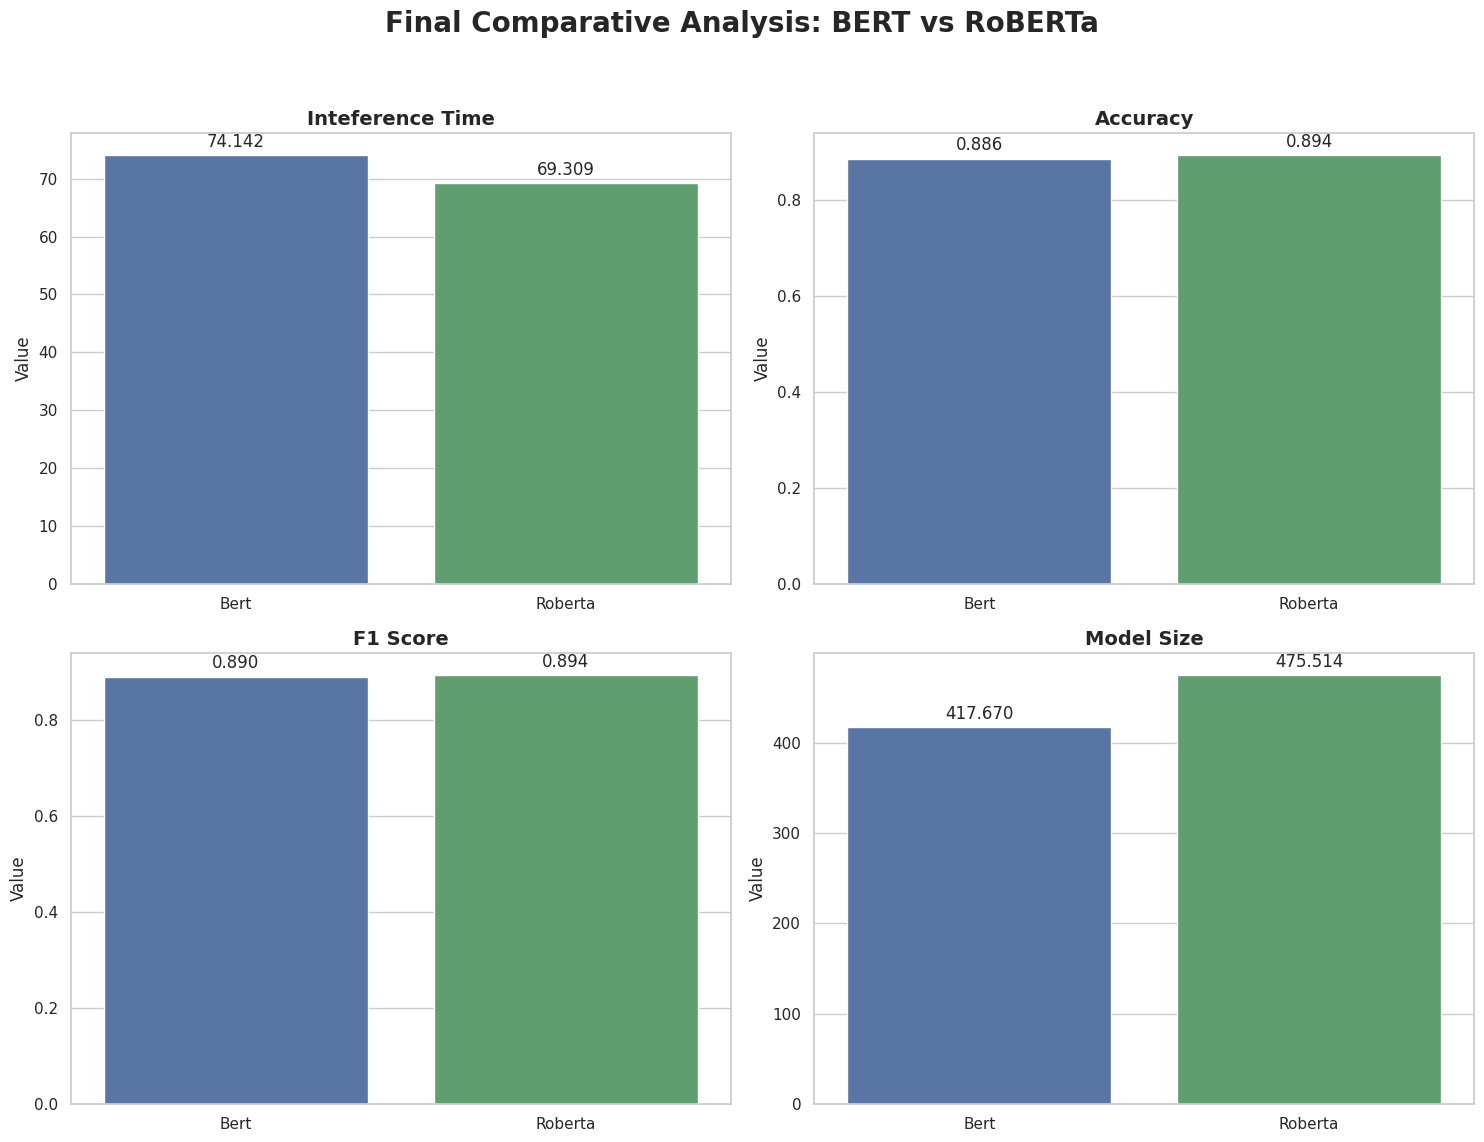

In [75]:
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Setup the visual style
sns.set_theme(style="whitegrid")
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('Final Comparative Analysis: BERT vs RoBERTa', fontsize=20, fontweight='bold')

# List of metrics to plot based on your DataFrame columns
metrics = ['Inteference Time', 'Accuracy', 'f1_Score', 'model_size']
colors = ['#4C72B0', '#55A868'] # Blue for BERT, Green for RoBERTa

# 2. Iterate through metrics and create subplots
for i, metric in enumerate(metrics):
    row = i // 2
    col = i % 2

    # Create the bar plot
    sns.barplot(x=final_report.index, y=final_report[metric], ax=axes[row, col], palette=colors)

    # Add labels and titles
    axes[row, col].set_title(f'{metric.replace("_", " ").title()}', fontsize=14, fontweight='bold')
    axes[row, col].set_xlabel('')
    axes[row, col].set_ylabel('Value')

    # Add numerical labels on top of bars
    for container in axes[row, col].containers:
        axes[row, col].bar_label(container, fmt='%.3f', padding=3)

# 3. Fine-tuning the layout
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()